# Data Preparation (Visium .h5 file)

In [1]:
import scanpy as sc
import mnmstpy as mnmst
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
sys.path.append('../')
from src import logger as l
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
section_id = "151675"
input_dir = os.path.join('../data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5')

sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=1)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

View of AnnData object with n_obs × n_vars = 3592 × 3001
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [3]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.00362314084367
num_nbrs: 3001


In [4]:
sc.pp.pca(enhanced_adata)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x
spatial_network = cell_spatial.A

### Load ground truth

In [5]:
Ann_df = pd.read_csv(os.path.join('../data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

# Running stACN (Raw CPU version)

In [ ]:
import src.st_acn as stACN
import src.logger as l
import os

output_data_path = "./Output/"
log_path = os.path.join(output_data_path, 'log')
os.makedirs(log_path, exist_ok=True)
l.initlog(log_path)
l.logger.info(f'[call] run st_acn_master')
Z_all =  stACN.st_acn(expression, spatial_network, lamb=0.001, dim=200)
l.logger.info(f'[call] run st_acn_master done')

2024-07-21 00:34:04,425 INFO 283392826.py:9  :  [call] run st_acn_master
[st_acn] Iter 3: err=['1.0008e+00', '1.0145e+00'], max_err=7.5321e+00, thresh=1.0000e-06:   8%|████████▍                                                                                                | 4/50 [02:29<28:50, 37.61s/it]

# Clustering (Leiden), we also provide tutorials of using Spectral Clustering

In [ ]:
import igraph as ig
import leidenalg
from natsort import natsorted
l.logger.info("[cluster] begin")
sources, targets = Z_all.nonzero()
ans_weight = Z_all[sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(Z_all.shape[0])
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight

In [8]:
partition_type = leidenalg.RBConfigurationVertexPartition
# clustering proper
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42,'resolution_parameter': 1.2}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)
adata.obs['stACN'] = leiden_label
adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, leiden_label)

['5', '2', '1', '0', '4', ..., '3', '1', '1', '4', '1']
Length: 3592
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']


0.6227927943540711

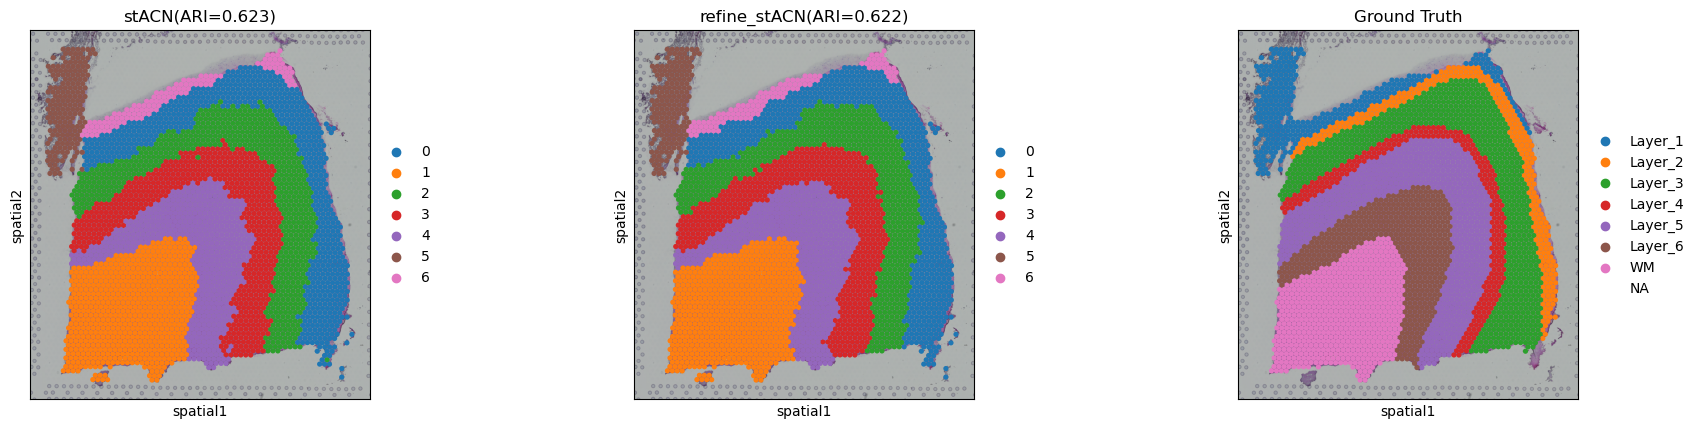

In [9]:
from src.utils import refine
weights_adj = cell_spatial.A
refined_pred = refine(sample_id=adata.obs.index.tolist(), pred=adata.obs['stACN'].tolist(),dis=weights_adj, shape="hexagon")
adata.obs["refined_pred"] = refined_pred
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
stACN_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['stACN'])
refine_ari = adjusted_rand_score(pd.Categorical(adata.obs['Ground Truth']).codes, adata.obs['refined_pred'])
sc.pl.spatial(adata, color=['stACN', 'refined_pred', 'Ground Truth'], title=['stACN(ARI=%.3f)'% stACN_ari, 'refine_stACN(ARI=%.3f)'%refine_ari, 'Ground Truth'], size=1.5)